In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sortedcontainers import SortedSet

In [2]:
root = 'C:/Users/meerkat/'
#root = 'C:/Users/cloftus/'



In [3]:
os.chdir( root + "Documents/social_sleep/DATA/gps_acc_data" )
os.listdir()

['acc_dat.csv', 'gps_dat.csv', 'Papio Anubis Mpala 2019.csv']

Papio Anubis Mpala 2019 is the file downloaded directly from Movebank, downloaded with all sensor types

In [4]:
dat1 = pd.read_csv('Papio Anubis Mpala 2019.csv', header=0)

C:\Users\meerkat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,9,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Here we can see all the columns of the data. As expected, we have both GPS and accelerometry in this data set

In [5]:
list(dat1)

['event-id',
 'visible',
 'timestamp',
 'location-long',
 'location-lat',
 'bar:barometric-pressure',
 'data-decoding-software',
 'eobs:acceleration-axes',
 'eobs:acceleration-sampling-frequency-per-axis',
 'eobs:accelerations-raw',
 'eobs:activity',
 'eobs:activity-samples',
 'eobs:battery-voltage',
 'eobs:fix-battery-voltage',
 'eobs:horizontal-accuracy-estimate',
 'eobs:key-bin-checksum',
 'eobs:speed-accuracy-estimate',
 'eobs:start-timestamp',
 'eobs:status',
 'eobs:temperature',
 'eobs:type-of-fix',
 'eobs:used-time-to-get-fix',
 'gps:dop',
 'gps:satellite-count',
 'ground-speed',
 'heading',
 'height-above-ellipsoid',
 'import-marked-outlier',
 'mag:magnetic-field-raw-x',
 'mag:magnetic-field-raw-y',
 'mag:magnetic-field-raw-z',
 'orientation:quaternion-raw-w',
 'orientation:quaternion-raw-x',
 'orientation:quaternion-raw-y',
 'orientation:quaternion-raw-z',
 'sensor-type',
 'individual-taxon-canonical-name',
 'tag-local-identifier',
 'individual-local-identifier',
 'study-name'

trim the data set to just include the tag, timestamp, ACC sampling frequency, and ACC

In [6]:
dat1 = dat1[ [ 'tag-local-identifier', 'timestamp', 'eobs:acceleration-sampling-frequency-per-axis',
 'eobs:accelerations-raw'] ]

In [7]:
dat1.head()

,tag-local-identifier,timestamp,eobs:acceleration-sampling-frequency-per-axis,eobs:accelerations-raw
0,6903,2019-07-19 03:30:41.000,NaN,NaN
1,6903,2019-07-19 03:30:42.000,NaN,NaN
2,6903,2019-07-19 03:30:43.000,NaN,NaN
3,6903,2019-07-19 03:30:44.000,NaN,NaN
4,6903,2019-07-19 03:30:45.000,NaN,NaN


In [8]:
# turn the timestamp into a datetime element
dat1[ 'timestamp' ] = pd.to_datetime( dat1[ 'timestamp' ] )

#dat1 = dat1.sort_values( by = ['tag-local-identifier', 'timestamp'] )

In [9]:
# rename the columns
dat1 = dat1.rename( columns = {'tag-local-identifier': 'tag', 'eobs:acceleration-sampling-frequency-per-axis': 'samp_freq', 'eobs:accelerations-raw': 'acc'} )

In [10]:
# remove the rows that are missing the ACC data
dat1 = dat1.dropna()

In [11]:
# check the different sampling frequencies that are present in the data set
set( dat1[ 'samp_freq' ])

{12.0, 20.0, 56.23}

In [12]:
## see how many unique days of data there are
len ( set( dat1[ 'timestamp' ].dt.date ) )

31

In [13]:
## change the directory to the DATA folder of the social_sleep repository
os.makedirs( root + "Documents/social_sleep/DATA/sleep_analysis_data/", exist_ok = True )

os.chdir( root + "Documents/social_sleep/DATA/sleep_analysis_data/" )

In [14]:
## save the acc data 
dat1.to_csv("acc_all_trim.csv", index = False)

In [15]:
## make the tag column into class string
dat1[ 'tag' ] = dat1[ 'tag' ].map( str )

In [16]:
# turn the timestamp into a datetime element
dat1[ 'timestamp' ] = pd.to_datetime( dat1[ 'timestamp' ] )


In [17]:
# we want to see how many ACC measurements each row has. We will loop through every row of the dataset and measure how many individual measurements of ACC each row has

fixes = list( map( lambda x: len( x.split( ' ' ) ), dat1[ 'acc' ] ) )


In [18]:
set( fixes ) ## gives the different number of ACC measurements collected on each row. To determine the sampling rate, we would divide these by 3 (because there are three axes) and by the duration of the sampling on each row

{36, 120}

(array([9262769.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  636158.]),
 array([ 36. ,  44.4,  52.8,  61.2,  69.6,  78. ,  86.4,  94.8, 103.2,
        111.6, 120. ]),
 <BarContainer object of 10 artists>)

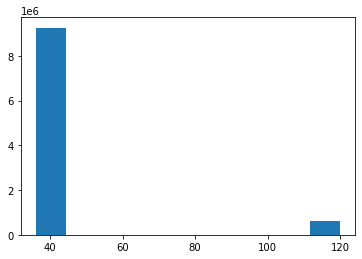

In [19]:
plt.hist( fixes ) # most of the rows have 36 ACC measurements. This is the continuous ACC taken during the day which is taken at 12 Hz/axis. Each row represents one second
# the rest of the rows have 120 ACC measurements. These are the bursts that are taken every minute on the minute during the night. There are 40 measurements per axis, collected for the duration of slightly less than a second (because they are collected at about 55 Hz) for the 2000s collars and for the 6000s collars, they are 40 measurements per axis taken for 2 seconds (because they are collected at 20 Hz) 

To match the sampling rate across the data, I downsample and interpolated the data to decrease to a sampling rate of 12 Hz. This interpolation is below. I don't need to interpolate beyond seven-tenths beyond the second, because the nighttime bursts only last for seven-tenths of a second, and the daytime data will be made to match the night-time data, so better to remove everything after seven-tenths of a second now

In [20]:
hz_12 = np.linspace( 0, 1, 13 )
hz_55 = np.linspace( 0, 0.711, 40 )
hz_20 = np.linspace( 0, 2, 41 )

In [21]:
hz_20

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  ])

In [22]:
hz_12

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        ])

In [23]:
hz_55

array([0.        , 0.01823077, 0.03646154, 0.05469231, 0.07292308,
       0.09115385, 0.10938462, 0.12761538, 0.14584615, 0.16407692,
       0.18230769, 0.20053846, 0.21876923, 0.237     , 0.25523077,
       0.27346154, 0.29169231, 0.30992308, 0.32815385, 0.34638462,
       0.36461538, 0.38284615, 0.40107692, 0.41930769, 0.43753846,
       0.45576923, 0.474     , 0.49223077, 0.51046154, 0.52869231,
       0.54692308, 0.56515385, 0.58338462, 0.60161538, 0.61984615,
       0.63807692, 0.65630769, 0.67453846, 0.69276923, 0.711     ])

In [24]:
final_tag_col = []
final_timestamp_col = []
final_samp_freq_col = []
final_acc_col = []

for i in range( dat1.shape[0]):
    
    if dat1.iloc[ i, 2 ] == 56.23:
        
        xyz = dat1.iloc[i, 3].split( ' ' )

        x = xyz[0::3]
        y = xyz[1::3]
        z = xyz[2::3]

        new_x = [ int(x[0]) ]
        new_y = [ int(y[0]) ]
        new_z = [ int(z[0]) ]

        new_x.append( np.average( [ int( x[4]) , int( x[5] ) ], weights = [ (hz_55[5] - hz_12[1] ) , ( hz_12[1] - hz_55[4] ) ] ) )
        new_x.append( np.average( [ int( x[9]) , int( x[10] ) ], weights = [ (hz_55[10] - hz_12[2] ) , ( hz_12[2] - hz_55[9] ) ] ) )
        new_x.append( np.average( [ int( x[13]) , int( x[14] ) ], weights = [ (hz_55[14] - hz_12[3] ) , ( hz_12[3] - hz_55[13] ) ] ) )
        new_x.append( np.average( [ int( x[18]) , int( x[19] ) ], weights = [ (hz_55[19] - hz_12[4] ) , ( hz_12[4] - hz_55[18] ) ] ) )
        new_x.append( np.average( [ int( x[22]) , int( x[23] ) ], weights = [ (hz_55[23] - hz_12[5] ) , ( hz_12[5] - hz_55[22] ) ] ) )
        new_x.append( np.average( [ int( x[27]) , int( x[28] ) ], weights = [ (hz_55[28] - hz_12[6] ) , ( hz_12[6] - hz_55[27] ) ] ) )
        new_x.append( np.average( [ int( x[31]) , int( x[32] ) ], weights = [ (hz_55[32] - hz_12[7] ) , ( hz_12[7] - hz_55[31] ) ] ) )
        new_x.append( np.average( [ int( x[36]) , int( x[37] ) ], weights = [ (hz_55[37] - hz_12[8] ) , ( hz_12[8] - hz_55[36] ) ] ) )

        new_y.append( np.average( [ int( y[4]) , int( y[5] ) ], weights = [ (hz_55[5] - hz_12[1] ) , ( hz_12[1] - hz_55[4] ) ] ) )
        new_y.append( np.average( [ int( y[9]) , int( y[10] ) ], weights = [ (hz_55[10] - hz_12[2] ) , ( hz_12[2] - hz_55[9] ) ] ) )
        new_y.append( np.average( [ int( y[13]) , int( y[14] ) ], weights = [ (hz_55[14] - hz_12[3] ) , ( hz_12[3] - hz_55[13] ) ] ) )
        new_y.append( np.average( [ int( y[18]) , int( y[19] ) ], weights = [ (hz_55[19] - hz_12[4] ) , ( hz_12[4] - hz_55[18] ) ] ) )
        new_y.append( np.average( [ int( y[22]) , int( y[23] ) ], weights = [ (hz_55[23] - hz_12[5] ) , ( hz_12[5] - hz_55[22] ) ] ) )
        new_y.append( np.average( [ int( y[27]) , int( y[28] ) ], weights = [ (hz_55[28] - hz_12[6] ) , ( hz_12[6] - hz_55[27] ) ] ) )
        new_y.append( np.average( [ int( y[31]) , int( y[32] ) ], weights = [ (hz_55[32] - hz_12[7] ) , ( hz_12[7] - hz_55[31] ) ] ) )
        new_y.append( np.average( [ int( y[36]) , int( y[37] ) ], weights = [ (hz_55[37] - hz_12[8] ) , ( hz_12[8] - hz_55[36] ) ] ) )

        new_z.append( np.average( [ int( z[4]) , int( z[5] ) ], weights = [ (hz_55[5] - hz_12[1] ) , ( hz_12[1] - hz_55[4] ) ] ) )
        new_z.append( np.average( [ int( z[9]) , int( z[10] ) ], weights = [ (hz_55[10] - hz_12[2] ) , ( hz_12[2] - hz_55[9] ) ] ) )
        new_z.append( np.average( [ int( z[13]) , int( z[14] ) ], weights = [ (hz_55[14] - hz_12[3] ) , ( hz_12[3] - hz_55[13] ) ] ) )
        new_z.append( np.average( [ int( z[18]) , int( z[19] ) ], weights = [ (hz_55[19] - hz_12[4] ) , ( hz_12[4] - hz_55[18] ) ] ) )
        new_z.append( np.average( [ int( z[22]) , int( z[23] ) ], weights = [ (hz_55[23] - hz_12[5] ) , ( hz_12[5] - hz_55[22] ) ] ) )
        new_z.append( np.average( [ int( z[27]) , int( z[28] ) ], weights = [ (hz_55[28] - hz_12[6] ) , ( hz_12[6] - hz_55[27] ) ] ) )
        new_z.append( np.average( [ int( z[31]) , int( z[32] ) ], weights = [ (hz_55[32] - hz_12[7] ) , ( hz_12[7] - hz_55[31] ) ] ) )
        new_z.append( np.average( [ int( z[36]) , int( z[37] ) ], weights = [ (hz_55[37] - hz_12[8] ) , ( hz_12[8] - hz_55[36] ) ] ) )
      
        full_acc = [ [ m, n, p ]  for m, n, p in zip( new_x , new_y, new_z )]

        new_xyz = []
        for sublist in full_acc:
            for item in sublist:
                new_xyz.append(item)

        new_xyz = list( map( str, new_xyz ))
        final_xyz = ' '.join(new_xyz)

        final_tag_col.append( dat1.iloc[ i, 0 ] )
        final_timestamp_col.append( dat1.iloc[ i, 1 ] )
        final_samp_freq_col.append( dat1.iloc[ i, 2 ] )

        final_acc_col.append( final_xyz )

    else:
        
        if dat1.iloc[ i, 2 ] == 20:
            

            xyz = dat1.iloc[i, 3].split( ' ' )

            x = xyz[0::3]
            y = xyz[1::3]
            z = xyz[2::3]

            new_x = [ int(x[0]) ]
            new_y = [ int(y[0]) ]
            new_z = [ int(z[0]) ]

            new_x.append( np.average( [ int( x[1]) , int( x[2] ) ], weights = [ (hz_20[2] - hz_12[1] ) , ( hz_12[1] - hz_20[1] ) ] ) )
            new_x.append( np.average( [ int( x[3]) , int( x[4] ) ], weights = [ (hz_20[4] - hz_12[2] ) , ( hz_12[2] - hz_20[3] ) ] ) )
            new_x.append( int( x[5] ) )
            new_x.append( np.average( [ int( x[6]) , int( x[7] ) ], weights = [ (hz_20[7] - hz_12[4] ) , ( hz_12[4] - hz_20[6] ) ] ) )
            new_x.append( np.average( [ int( x[8]) , int( x[9] ) ], weights = [ (hz_20[9] - hz_12[5] ) , ( hz_12[5] - hz_20[8] ) ] ) )
            new_x.append( int( x[10] ) )
            new_x.append( np.average( [ int( x[11]) , int( x[12] ) ], weights = [ (hz_20[12] - hz_12[7] ) , ( hz_12[7] - hz_20[11] ) ] ) )
            new_x.append( np.average( [ int( x[13]) , int( x[14] ) ], weights = [ (hz_20[14] - hz_12[8] ) , ( hz_12[8] - hz_20[13] ) ] ) )

            new_y.append( np.average( [ int( y[1]) , int( y[2] ) ], weights = [ (hz_20[2] - hz_12[1] ) , ( hz_12[1] - hz_20[1] ) ] ) )
            new_y.append( np.average( [ int( y[3]) , int( y[4] ) ], weights = [ (hz_20[4] - hz_12[2] ) , ( hz_12[2] - hz_20[3] ) ] ) )
            new_y.append( int( y[5] ) )
            new_y.append( np.average( [ int( y[6]) , int( y[7] ) ], weights = [ (hz_20[7] - hz_12[4] ) , ( hz_12[4] - hz_20[6] ) ] ) )
            new_y.append( np.average( [ int( y[8]) , int( y[9] ) ], weights = [ (hz_20[9] - hz_12[5] ) , ( hz_12[5] - hz_20[8] ) ] ) )
            new_y.append( int( y[10] ) )
            new_y.append( np.average( [ int( y[11]) , int( y[12] ) ], weights = [ (hz_20[12] - hz_12[7] ) , ( hz_12[7] - hz_20[11] ) ] ) )
            new_y.append( np.average( [ int( y[13]) , int( y[14] ) ], weights = [ (hz_20[14] - hz_12[8] ) , ( hz_12[8] - hz_20[13] ) ] ) )

            new_z.append( np.average( [ int( z[1]) , int( z[2] ) ], weights = [ (hz_20[2] - hz_12[1] ) , ( hz_12[1] - hz_20[1] ) ] ) )
            new_z.append( np.average( [ int( z[3]) , int( z[4] ) ], weights = [ (hz_20[4] - hz_12[2] ) , ( hz_12[2] - hz_20[3] ) ] ) )
            new_z.append( int( z[5] ) )
            new_z.append( np.average( [ int( z[6]) , int( z[7] ) ], weights = [ (hz_20[7] - hz_12[4] ) , ( hz_12[4] - hz_20[6] ) ] ) )
            new_z.append( np.average( [ int( z[8]) , int( z[9] ) ], weights = [ (hz_20[9] - hz_12[5] ) , ( hz_12[5] - hz_20[8] ) ] ) )
            new_z.append( int( z[10] ) )
            new_z.append( np.average( [ int( z[11]) , int( z[12] ) ], weights = [ (hz_20[12] - hz_12[7] ) , ( hz_12[7] - hz_20[11] ) ] ) )
            new_z.append( np.average( [ int( z[13]) , int( z[14] ) ], weights = [ (hz_20[14] - hz_12[8] ) , ( hz_12[8] - hz_20[13] ) ] ) )

            full_acc = [ [ m, n, p ]  for m, n, p in zip( new_x , new_y, new_z )]

            new_xyz = []
            for sublist in full_acc:
                for item in sublist:
                    new_xyz.append(item)

            new_xyz = list( map( str, new_xyz ))
            final_xyz = ' '.join(new_xyz)

            final_tag_col.append( dat1.iloc[ i, 0 ] )
            final_timestamp_col.append( dat1.iloc[ i, 1 ] )
            final_samp_freq_col.append( dat1.iloc[ i, 2 ] )

            final_acc_col.append( final_xyz )

            
            new_x = [ int(x[20]) ]
            new_y = [ int(y[20]) ]
            new_z = [ int(z[20]) ]

            new_x.append( np.average( [ int( x[21]) , int( x[22] ) ], weights = [ (hz_20[2] - hz_12[1] ) , ( hz_12[1] - hz_20[1] ) ] ) )
            new_x.append( np.average( [ int( x[23]) , int( x[24] ) ], weights = [ (hz_20[4] - hz_12[2] ) , ( hz_12[2] - hz_20[3] ) ] ) )
            new_x.append( int( x[25] ) )
            new_x.append( np.average( [ int( x[26]) , int( x[27] ) ], weights = [ (hz_20[7] - hz_12[4] ) , ( hz_12[4] - hz_20[6] ) ] ) )
            new_x.append( np.average( [ int( x[28]) , int( x[29] ) ], weights = [ (hz_20[9] - hz_12[5] ) , ( hz_12[5] - hz_20[8] ) ] ) )
            new_x.append( int( x[30] ) )
            new_x.append( np.average( [ int( x[31]) , int( x[32] ) ], weights = [ (hz_20[12] - hz_12[7] ) , ( hz_12[7] - hz_20[11] ) ] ) )
            new_x.append( np.average( [ int( x[33]) , int( x[34] ) ], weights = [ (hz_20[14] - hz_12[8] ) , ( hz_12[8] - hz_20[13] ) ] ) )

            new_y.append( np.average( [ int( y[21]) , int( y[22] ) ], weights = [ (hz_20[2] - hz_12[1] ) , ( hz_12[1] - hz_20[1] ) ] ) )
            new_y.append( np.average( [ int( y[23]) , int( y[24] ) ], weights = [ (hz_20[4] - hz_12[2] ) , ( hz_12[2] - hz_20[3] ) ] ) )
            new_y.append( int( y[25] ) )
            new_y.append( np.average( [ int( y[26]) , int( y[27] ) ], weights = [ (hz_20[7] - hz_12[4] ) , ( hz_12[4] - hz_20[6] ) ] ) )
            new_y.append( np.average( [ int( y[28]) , int( y[29] ) ], weights = [ (hz_20[9] - hz_12[5] ) , ( hz_12[5] - hz_20[8] ) ] ) )
            new_y.append( int( y[30] ) )
            new_y.append( np.average( [ int( y[31]) , int( y[32] ) ], weights = [ (hz_20[12] - hz_12[7] ) , ( hz_12[7] - hz_20[11] ) ] ) )
            new_y.append( np.average( [ int( y[33]) , int( y[34] ) ], weights = [ (hz_20[14] - hz_12[8] ) , ( hz_12[8] - hz_20[13] ) ] ) )

            new_z.append( np.average( [ int( z[21]) , int( z[22] ) ], weights = [ (hz_20[2] - hz_12[1] ) , ( hz_12[1] - hz_20[1] ) ] ) )
            new_z.append( np.average( [ int( z[23]) , int( z[24] ) ], weights = [ (hz_20[4] - hz_12[2] ) , ( hz_12[2] - hz_20[3] ) ] ) )
            new_z.append( int( z[25] ) )
            new_z.append( np.average( [ int( z[26]) , int( z[27] ) ], weights = [ (hz_20[7] - hz_12[4] ) , ( hz_12[4] - hz_20[6] ) ] ) )
            new_z.append( np.average( [ int( z[28]) , int( z[29] ) ], weights = [ (hz_20[9] - hz_12[5] ) , ( hz_12[5] - hz_20[8] ) ] ) )
            new_z.append( int( z[30] ) )
            new_z.append( np.average( [ int( z[31]) , int( z[32] ) ], weights = [ (hz_20[12] - hz_12[7] ) , ( hz_12[7] - hz_20[11] ) ] ) )
            new_z.append( np.average( [ int( z[33]) , int( z[34] ) ], weights = [ (hz_20[14] - hz_12[8] ) , ( hz_12[8] - hz_20[13] ) ] ) )

            full_acc = [ [ m, n, p ]  for m, n, p in zip( new_x , new_y, new_z )]

            new_xyz = []
            for sublist in full_acc:
                for item in sublist:
                    new_xyz.append(item)

            new_xyz = list( map( str, new_xyz ) )
            final_xyz = ' '.join(new_xyz)

            final_tag_col.append( dat1.iloc[ i, 0 ] )
            final_timestamp_col.append( dat1.iloc[ i, 1 ] + dt.timedelta( seconds = 1 ) )
            final_samp_freq_col.append( dat1.iloc[ i, 2 ] )

            final_acc_col.append( final_xyz )

        else:
            
            if dat1.iloc[ i, 2 ] == 12:
                
                xyz = dat1.iloc[i, 3].split( ' ' )

                x = xyz[0::3]
                y = xyz[1::3]
                z = xyz[2::3]

                new_x = x[:9]
                new_y = y[:9]
                new_z = z[:9]

                full_acc = [ [ m, n, p ]  for m, n, p in zip( new_x , new_y, new_z )]

                new_xyz = []
                for sublist in full_acc:
                    for item in sublist:
                        new_xyz.append(item)

                new_xyz = list( map( str, new_xyz ))
                final_xyz = ' '.join(new_xyz)

                final_tag_col.append( dat1.iloc[ i, 0 ] )
                final_timestamp_col.append( dat1.iloc[ i, 1 ] )
                final_samp_freq_col.append( dat1.iloc[ i, 2 ] )

                final_acc_col.append( final_xyz )

            else:
                
                problemoooo
           
    if (i % 100000) == 0:
        
        print( i / dat1.shape[ 0 ], flush = True )

            
    

0.0
0.0101021050059264
0.0202042100118528
0.0303063150177792
0.0404084200237056
0.050510525029632
0.0606126300355584
0.0707147350414848
0.0808168400474112
0.0909189450533376
0.101021050059264
0.1111231550651904
0.1212252600711168
0.1313273650770432
0.1414294700829696
0.151531575088896
0.1616336800948224
0.1717357851007488
0.1818378901066752
0.1919399951126016
0.202042100118528
0.2121442051244544
0.2222463101303808
0.2323484151363072
0.2424505201422336
0.25255262514816
0.2626547301540864
0.2727568351600128
0.2828589401659392
0.2929610451718656
0.303063150177792
0.3131652551837184
0.3232673601896448
0.3333694651955712
0.3434715702014976
0.353573675207424
0.3636757802133504
0.3737778852192768
0.3838799902252032
0.3939820952311296
0.404084200237056
0.4141863052429824
0.4242884102489088
0.4343905152548352
0.4444926202607616
0.454594725266688
0.4646968302726144
0.4747989352785408
0.4849010402844672
0.4950031452903936
0.50510525029632
0.5152073553022464
0.5253094603081728
0.5354115653140992
0

In [25]:
dat = pd.DataFrame( { 'tag' : final_tag_col, 'timestamp': final_timestamp_col, 'samp_freq': final_samp_freq_col, 'acc_interp': final_acc_col } )

In [26]:
list( dat )

['tag', 'timestamp', 'samp_freq', 'acc_interp']

In [27]:
## see how many ACC measurements are in each second for the downsampled and interpolated ACC. We should have 9 measurements per axis per second (12 Hz sampling rate for 0.71 seconds)
set( list( map( lambda x: len( x.split( ' ' ) ), dat.iloc[ :, 3 ] ) ) )

{27}

In [28]:
# make the timestamp the index. This makes it easier to subset by the timestamp
dat.set_index( 'timestamp', inplace = True )

In [29]:
# save the tag names
tag_names = SortedSet( dat[ 'tag' ] ) 

In [30]:
## this cell is just to check what data exists for each tag at different times of the day (because the sampling changed between the daytime and nighttime)
for tag in tag_names:
    
    id_dat = dat[ dat['tag'] == tag ]
    
    day_dat = id_dat.between_time( start_time = '10:00:00', end_time = '13:00:00' )
    
    night_dat = id_dat.between_time( start_time = '18:00:00', end_time = '20:00:00' )
    
    print( tag, flush = True )
    
    if day_dat.shape[ 0 ] == 0:
        print( "no day data")
    
    else:
        print( day_dat.iloc[ 0, : ], flush = True )
        fixes = day_dat[ 'acc_interp' ].iloc[ 0 ].split( ' ' )
        print( fixes, flush = True )
        print( len( fixes ) ) 
    
    if night_dat.shape[ 0 ] == 0:
        
        print( "no night data" )
        
    else:

        print( night_dat.iloc[ 0, : ], flush = True )
        print( night_dat[ 'acc_interp' ].iloc[ 0 ], flush = True )
        fixes = night_dat[ 'acc_interp' ].iloc[ 0 ].split( ' ' )
        print( fixes, flush = True )
        print( len( fixes ) ) 

    print( )

2428
tag                                                        2428
samp_freq                                                    12
acc_interp    2352 1883 1648 2353 1897 1645 2342 1913 1677 2...
Name: 2019-07-19 10:00:00, dtype: object
['2352', '1883', '1648', '2353', '1897', '1645', '2342', '1913', '1677', '2344', '1898', '1673', '2352', '1892', '1672', '2344', '1893', '1680', '2348', '1880', '1670', '2352', '1890', '1667', '2336', '1888', '1640']
27
tag                                                        2428
samp_freq                                                 56.23
acc_interp    2216 1844 1582 2211.5710267229256 1843.9999999...
Name: 2019-07-19 18:00:00, dtype: object
2216 1844 1582 2211.5710267229256 1843.9999999999998 1578.7074542897326 2212.8579465541493 1827.4149085794656 1576.8523206751056 2217.7130801687763 1832.7046413502107 1574.5738396624472 2218.284106891702 1823.579465541491 1571.9774964838255 2213.130801687764 1826.3178621659633 1576.1308016877636 2206.0168776

27

2447
tag                                                        2447
samp_freq                                                    12
acc_interp    2312 2028 1567 2317 2052 1539 2302 1984 1537 2...
Name: 2019-07-19 10:00:00, dtype: object
['2312', '2028', '1567', '2317', '2052', '1539', '2302', '1984', '1537', '2348', '2078', '1569', '2360', '2032', '1606', '2343', '2001', '1601', '2341', '2034', '1578', '2333', '2058', '1585', '2330', '2026', '1593']
27
tag                                                        2447
samp_freq                                                 56.23
acc_interp    2304 1812 1609 2303.710267229255 1837.13642756...
Name: 2019-07-19 18:00:00, dtype: object
2304 1812 1609 2303.710267229255 1837.1364275668075 1600.4289732770744 2302.0 1839.869198312236 1602.0 2305.721518987342 1829.4430379746836 1594.8523206751054 2302.863572433193 1831.4767932489453 1597.7046413502112 2305.1167369901545 1827.1308016877636 1599.0 2305.181434599156 1819.9831223628692 1598.886

27

6890
tag                                                        6890
samp_freq                                                    20
acc_interp    2396 2429 1770 2327.3333333333335 2408.6666666...
Name: 2019-08-06 10:00:08, dtype: object
['2396', '2429', '1770', '2327.3333333333335', '2408.6666666666665', '1862.3333333333335', '2349.666666666667', '2306.333333333333', '1854.3333333333333', '2425', '2304', '1879', '2433.6666666666665', '2245.0', '1871.0', '2313.6666666666665', '2303.6666666666665', '1834.6666666666667', '2408', '2354', '1874', '2371.6666666666665', '2313.0', '1871.3333333333333', '2555.3333333333335', '2614.3333333333335', '1721.3333333333333']
27
tag                                                        6890
samp_freq                                                    20
acc_interp    2453 2295 1890 2451.9999999999995 2294.6666666...
Name: 2019-07-19 18:00:08, dtype: object
2453 2295 1890 2451.9999999999995 2294.666666666667 1889.0 2454.3333333333335 2295.33333333

27
tag                                                        6900
samp_freq                                                    20
acc_interp    2260 2242 1637 2258.6666666666665 2241.0 1637....
Name: 2019-07-19 18:00:15, dtype: object
2260 2242 1637 2258.6666666666665 2241.0 1637.0 2258.333333333333 2242.0 1637.0 2259 2244 1636 2258.6666666666665 2241.0 1638.3333333333335 2260.333333333333 2241.0 1638.0 2259 2242 1638 2258.0 2241.333333333333 1636.6666666666665 2257.666666666667 2238.666666666667 1637.6666666666667
['2260', '2242', '1637', '2258.6666666666665', '2241.0', '1637.0', '2258.333333333333', '2242.0', '1637.0', '2259', '2244', '1636', '2258.6666666666665', '2241.0', '1638.3333333333335', '2260.333333333333', '2241.0', '1638.0', '2259', '2242', '1638', '2258.0', '2241.333333333333', '1636.6666666666665', '2257.666666666667', '2238.666666666667', '1637.6666666666667']
27

6903
tag                                                        6903
samp_freq                            

27

6927
no day data
tag                                                        6927
samp_freq                                                    20
acc_interp    1980 1483 1906 2014.3333333333333 1601.3333333...
Name: 2019-07-19 18:00:20, dtype: object
1980 1483 1906 2014.3333333333333 1601.3333333333335 1868.3333333333333 2011.9999999999998 1602.3333333333333 1823.3333333333333 1859 1548 1875 2002.3333333333333 1574.6666666666667 1823.0 2060.666666666667 1430.333333333334 1847.0 2156 1632 1828 2113.0 1681.0000000000002 1740.0000000000002 2150.0 1682.333333333333 1682.6666666666667
['1980', '1483', '1906', '2014.3333333333333', '1601.3333333333335', '1868.3333333333333', '2011.9999999999998', '1602.3333333333333', '1823.3333333333333', '1859', '1548', '1875', '2002.3333333333333', '1574.6666666666667', '1823.0', '2060.666666666667', '1430.333333333334', '1847.0', '2156', '1632', '1828', '2113.0', '1681.0000000000002', '1740.0000000000002', '2150.0', '1682.333333333333', '1682.66666666

In [31]:
# reset the index, so that the timestamp becomes a column and not the index again
dat.reset_index( inplace = True )

In [32]:
# save the resulting csv
dat.to_csv("all_burst_acc.csv", index = False)